Intro: The idea behind this approach was to take all the 2018-2019 data and use it to build a seperate model for each 2020 period. Differences in the overall accuracy of each model as well as shifts in the importance of different features to the model might indicate COVID-related change. 

This approach initially seemed pretty promising. The kitchen sink model (the model built on all available features) assigned the highest correlation coefficients to features which appeared highly topical, primarily author names: Ibram X. Kendi and Ta-Nehisi Coates during the height of the Black Lives Matter Protests, Sally Rooney as Normal People was released as a television series, Jeanine Cummins while American Dirt recieved significant press attention. Based on that model, it appeared that monthly review counts would be best predicted by understanding pop cultural trends at that moment rather than overall historical trends. The correlation matrix (in the feature selection notebook) supported the assumption that historical review counts would be less important. It seemed like we were going to find something very cool! 

However, the feature selection testing was a damp towel. For this process, I started with the baseline model and tested the impact of adding new features one at a time. Every single feature addition degraded model performance: we ended up right back at the baseline model. That model is exciting in that it performs fairly well, but it is of minimal use in analyzing 2020 trends. With potentially topical features no longer included, I'm not sure that the approach of building seperate models for each 2020 month is still viable. It might be best to drop the approach entirely, although taking a more granualar approach to feature selection could also make sense. 

In [1]:
import datetime
import numpy as np
import pandas as pd

import aggregator as ag
import monthly_modeler as mm

In [2]:
data_file_name_review = "distributed_data_collection/databases/review_data.csv"
data_file_name_book = "distributed_data_collection/databases/book_data.csv"

start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 9, 30)

book_columns = ["num_reviews", "num_ratings", "avg_rating", "book_author"]

Theoretically, we could test against multiple grains (ie, day, week, month, quarter). However, I am only working with month. I ruled out the quarterly grain because it wouldn't include enough 2020 time periods to observe a trend in model performance over time. Then because the maximum monthly review counts were in the seventies, I didn't feel I could split those further.

I want to drop binary feature columns which have a small number of values. The linear regression regularization will do a rigorous feature selection, so this step is mostly to reduce the amount of data that it has to process.

In [6]:
data_aggregator = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns, start_date, end_date, "month", clean_authors = True)
data_aggregator.aggregate("by_book")
data_aggregator.sparsity_filter(2)

time_periods_post = data_aggregator.get_annual_time_periods(2020)
data_train, data_test = data_aggregator.get_train_test_split(0.75)

Aggregator Initiated.
Processing Scraper Output...
Cleaning Author Data...
Author Data Cleaned.
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 5,572/7,072 columns. 1,500 columns remaining.


We want to iterate through: logorithmic transformation, regularization type, and alpha value. For the moment, I am turning logorithmic transformation off. It's pretty clear that it has no impact, and I don't want to keep running it while I experiment with other aspects of the modeling process.

In [7]:
alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

Here goes on modeling! We will select the best model for each time period based on MSE. The performance df captures the overall predictiveness of pre-period data on post-period data. We expect to see declines due to concept drift. Sharp dropoffs in performance might suggest larger changes in reading trends.

In [8]:
regression_processor = mm.Regression_Processor(data_train, data_test, time_periods_post, regression_types_list, is_log_options, alpha_list)
performance_df, model_dict = regression_processor.get_optimal_models()

print(performance_df.round(3))

10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
  post_period regression_type is_log  alpha  mse_test  r2_train  r2_test
0     2020-01           ridge  False  1.000     2.784     0.800    0.748
1     2020-02           ridge  False  1.000     1.777     0.720    0.645
2     2020-03           ridge  False  1.000     2.069     0.709    0.622
3     2020-04           ridge  False  1.000     3.009     0.768    0.674
4     2020-05           ridge  False  1.000     3.994     0.709    0.570
5     2020-06           ridge  False  1.000   

This is where it's really at! Understanding what features are most important to each model can help us understand the drivers of reading in each period.

In [9]:
coefficient_df = regression_processor.get_coefficient_df()
coefficient_df = regression_processor.print_top_coefficients(30)

                                                    review_count 2020-01
feature_name                                                            
book_author_Liz Moore                                           5.349556
book_author_Casey McQuiston                                     4.434177
book_author_Heather   Morris                                    3.383171
book_author_Kevin    Wilson                                     3.353948
book_author_Brian Freeman                                       3.336496
book_author_Simone St. James                                    3.087126
book_author_Dale Carnegie                                       2.422495
book_author_B.A. Paris                                          2.417172
book_author_Laura Hillenbrand                                  -2.381419
book_author_Denise Mina                                         2.345782
book_author_Ronan Farrow                                        2.188725
book_author_Abbi Waxman                            

I also want to understand the relative importance of each historical period. Even if it isn't the main driver, it should give some indication of whether trends are changing.

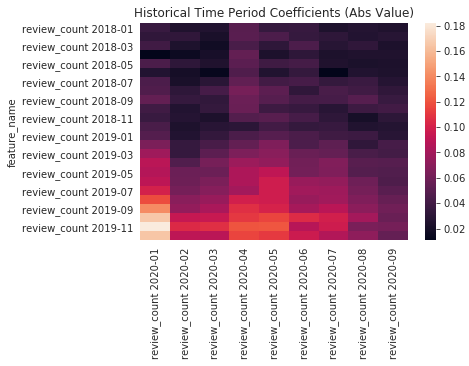

In [10]:
pre_period_importance = regression_processor.get_pre_period_importance()